Detected 35 potentially hazardous asteroids.


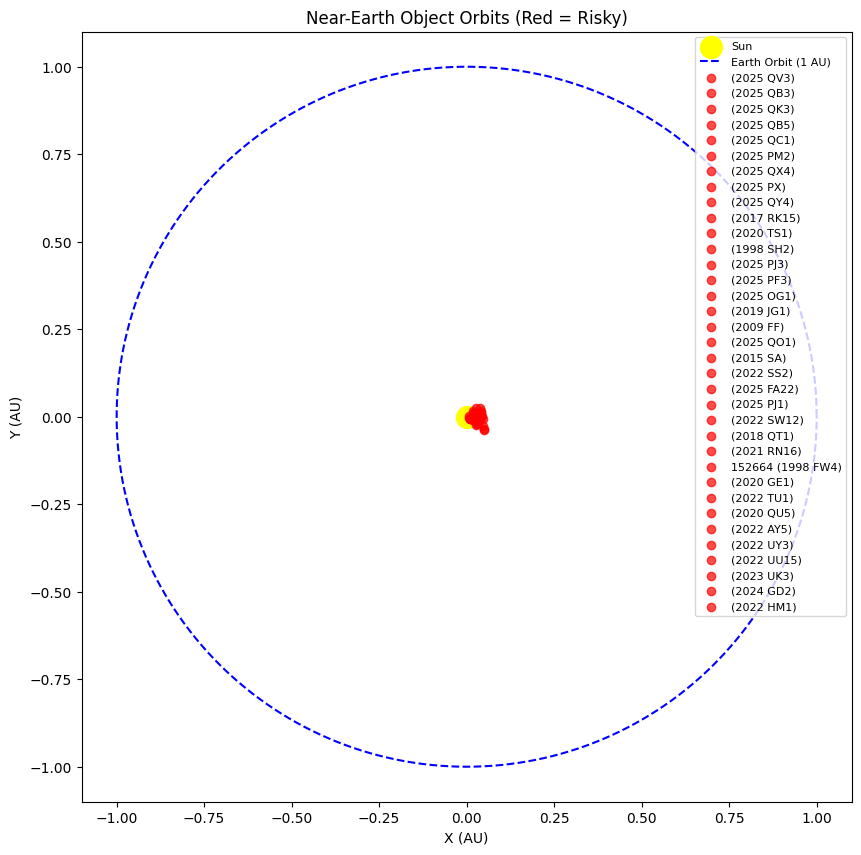

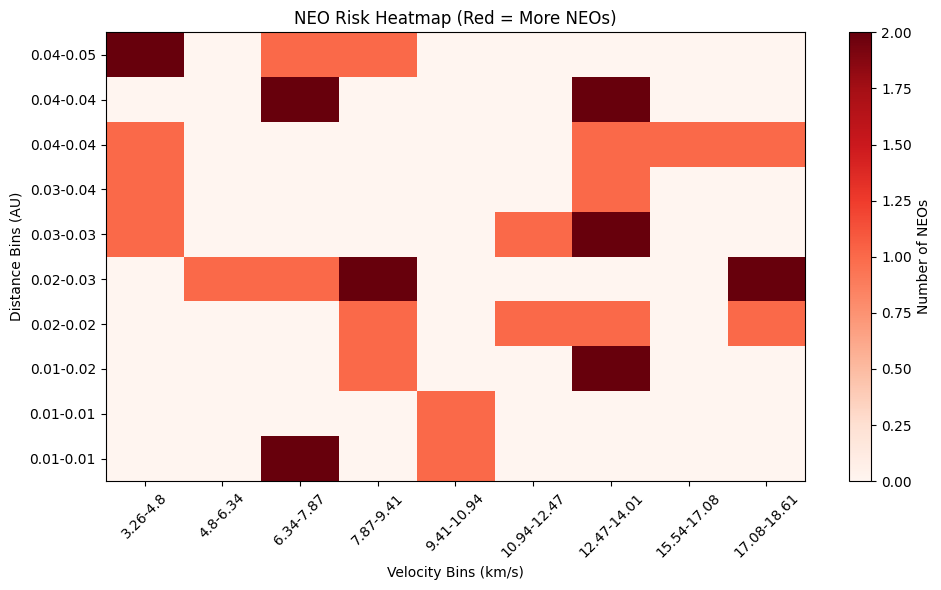

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

# =============================
# 1. Load Dataset
# =============================
df = pd.read_csv(r"C:\Users\hp\Downloads\NEO Earth Close Approaches.csv")
df.columns = df.columns.str.strip()

# Auto-detect columns
col_object = next((c for c in df.columns if 'object' in c.lower() or 'designation' in c.lower()), None)
col_date = next((c for c in df.columns if 'date' in c.lower()), None)
col_distance_min = next((c for c in df.columns if 'distance' in c.lower() and 'min' in c.lower()), None)
col_distance_nom = next((c for c in df.columns if 'distance' in c.lower() and 'nom' in c.lower()), None)
col_velocity = next((c for c in df.columns if 'v' in c.lower()), None)  # velocity column auto-detect

# Convert numeric columns
df[col_distance_min] = pd.to_numeric(df[col_distance_min], errors='coerce')
df[col_distance_nom] = pd.to_numeric(df[col_distance_nom], errors='coerce')
df[col_velocity] = pd.to_numeric(df[col_velocity], errors='coerce')

# =============================
# 2. Risk Detection
# =============================
threshold_au = 0.05
df['Risk'] = df[col_distance_min] <= threshold_au
risky_asteroids = df[df['Risk']]

print(f"Detected {len(risky_asteroids)} potentially hazardous asteroids.")

# =============================
# 3. 2D Orbit Plot (Matplotlib)
# =============================
plt.figure(figsize=(10,10))
ax = plt.gca()

# Plot Sun
ax.scatter(0,0,color='yellow', s=250, label='Sun')

# Earth orbit (1 AU circle)
theta = np.linspace(0,2*np.pi,500)
ax.plot(np.cos(theta), np.sin(theta), 'b--', label='Earth Orbit (1 AU)')

# Plot NEOs using nominal distances
for idx, row in df.head(50).iterrows():  # first 50 for clarity
    x = row[col_distance_nom] if not np.isnan(row[col_distance_nom]) else 0
    y = np.random.uniform(-x, x)
    color = 'red' if row['Risk'] else 'green'
    ax.scatter(x, y, color=color, alpha=0.7, label=row[col_object] if row['Risk'] else None)

ax.set_aspect('equal','box')
ax.set_xlabel('X (AU)')
ax.set_ylabel('Y (AU)')
ax.set_title('Near-Earth Object Orbits (Red = Risky)')
ax.legend(loc='upper right', fontsize=8)
plt.show()

# =============================
# 4. Interactive 3D Plot (Plotly)
# =============================
fig3d = go.Figure()

# Sun
fig3d.add_trace(go.Scatter3d(
    x=[0], y=[0], z=[0],
    mode='markers',
    marker=dict(size=8, color='yellow'),
    name='Sun'
))

# NEOs positions (randomized z for 3D effect)
for idx, row in df.head(50).iterrows():
    x = row[col_distance_nom] if not np.isnan(row[col_distance_nom]) else 0
    y = np.random.uniform(-x, x)
    z = np.random.uniform(-x, x)
    color = 'red' if row['Risk'] else 'green'
    fig3d.add_trace(go.Scatter3d(
        x=[x], y=[y], z=[z],
        mode='markers',
        marker=dict(size=5, color=color),
        hovertext=f"{row[col_object]}<br>Date: {row[col_date]}<br>Min Distance: {row[col_distance_min]:.4f} AU",
        name=row[col_object]
    ))

fig3d.update_layout(
    title="Interactive 3D Near-Earth Objects",
    scene=dict(xaxis_title='X (AU)', yaxis_title='Y (AU)', zaxis_title='Z (AU)'),
    height=700
)
fig3d.show()

# =============================
# 5. Risk Visualization Charts (Plotly)
# =============================

# Pie Chart: Risk Distribution
risk_counts = df['Risk'].value_counts()
fig_pie = px.pie(
    names=['Safe','Risky'],
    values=[risk_counts.get(False,0), risk_counts.get(True,0)],
    title="NEO Risk Distribution",
    color_discrete_map={'Safe':'green','Risky':'red'}
)
fig_pie.show()

# Bar Chart: Top risky asteroids
if not risky_asteroids.empty:
    fig_bar = px.bar(
        risky_asteroids.sort_values(col_distance_min),
        x=col_object,
        y=col_distance_min,
        color='Risk',
        title='Top Potentially Hazardous Asteroids (Closest Approach)',
        labels={col_distance_min:'Distance (AU)', col_object:'Asteroid Name'},
        color_discrete_map={True:'red', False:'green'}
    )
    fig_bar.show()

# =============================
# 7. Scatter Plot: Velocity vs Min Distance (Improved with jitter)
# =============================
scatter_df = df.head(100).copy()
scatter_df = scatter_df.dropna(subset=[col_distance_min, col_velocity])

# Create HighVelocity column (boolean) based on threshold
velocity_threshold = 25  # km/s
scatter_df['HighVelocity'] = scatter_df[col_velocity] > velocity_threshold

# Scale marker size and differentiate risky NEOs
scatter_df['HighVelocityNum'] = np.where(
    scatter_df['Risk'],
    scatter_df[col_velocity] / scatter_df[col_velocity].max() * 80,  # risky NEOs larger
    scatter_df[col_velocity] / scatter_df[col_velocity].max() * 30   # safe NEOs smaller
)

# Add jitter to avoid overlapping red dots
scatter_df['DistanceJitter'] = scatter_df[col_distance_min] + np.random.uniform(-0.002, 0.002, len(scatter_df))
scatter_df['VelocityJitter'] = scatter_df[col_velocity] + np.random.uniform(-0.5, 0.5, len(scatter_df))

fig_scatter = px.scatter(
    scatter_df,
    x='DistanceJitter',
    y='VelocityJitter',
    color='Risk',
    size='HighVelocityNum',
    opacity=0.8,
    title='Velocity vs Minimum Distance (Red = Risk)',
    labels={'DistanceJitter':'Min Distance (AU)', 'VelocityJitter':'Velocity (km/s)'},
    color_discrete_map={True:'red', False:'green'}
)
fig_scatter.show()

# =============================
# 8. Heatmap: Risk Clustering
# =============================
heat_df = df.head(100).copy()
heat_df = heat_df.dropna(subset=[col_distance_min, col_velocity])

# Bin distance and velocity
heat_df['DistanceBin'] = pd.cut(heat_df[col_distance_min], bins=10)
heat_df['VelocityBin'] = pd.cut(heat_df[col_velocity], bins=10)

# Group by bins and explicitly set observed=True to avoid FutureWarning
heatmap_data = heat_df.groupby(['DistanceBin','VelocityBin'], observed=True).size().unstack(fill_value=0)

plt.figure(figsize=(10,6))
plt.imshow(heatmap_data, cmap='Reds', origin='lower', aspect='auto')

# Set axis labels as bin ranges
plt.xticks(range(len(heatmap_data.columns)), [f'{round(interval.left,2)}-{round(interval.right,2)}' for interval in heatmap_data.columns], rotation=45)
plt.yticks(range(len(heatmap_data.index)), [f'{round(interval.left,2)}-{round(interval.right,2)}' for interval in heatmap_data.index])

plt.colorbar(label='Number of NEOs')
plt.xlabel('Velocity Bins (km/s)')
plt.ylabel('Distance Bins (AU)')
plt.title('NEO Risk Heatmap (Red = More NEOs)')
plt.tight_layout()
plt.show()


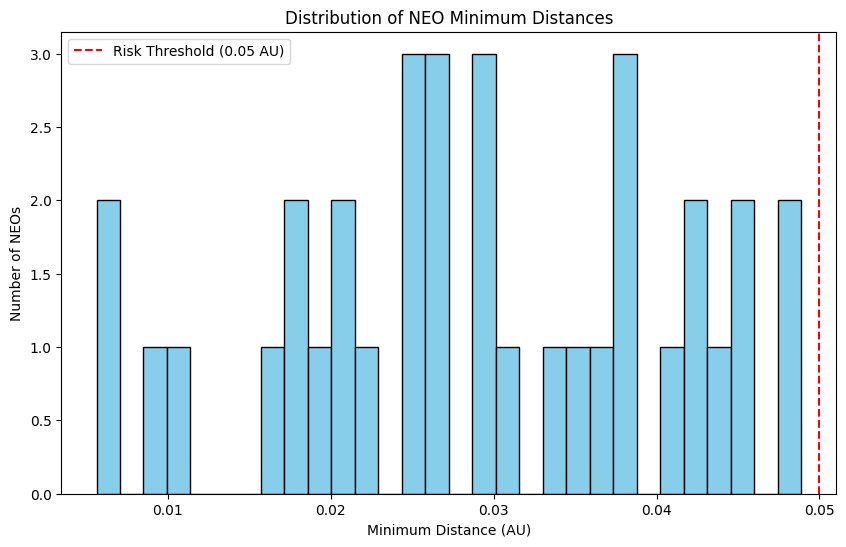

In [25]:
plt.figure(figsize=(10,6))
plt.hist(df[col_distance_min].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.axvline(threshold_au, color='red', linestyle='--', label='Risk Threshold (0.05 AU)')
plt.xlabel('Minimum Distance (AU)')
plt.ylabel('Number of NEOs')
plt.title('Distribution of NEO Minimum Distances')
plt.legend()
plt.show()


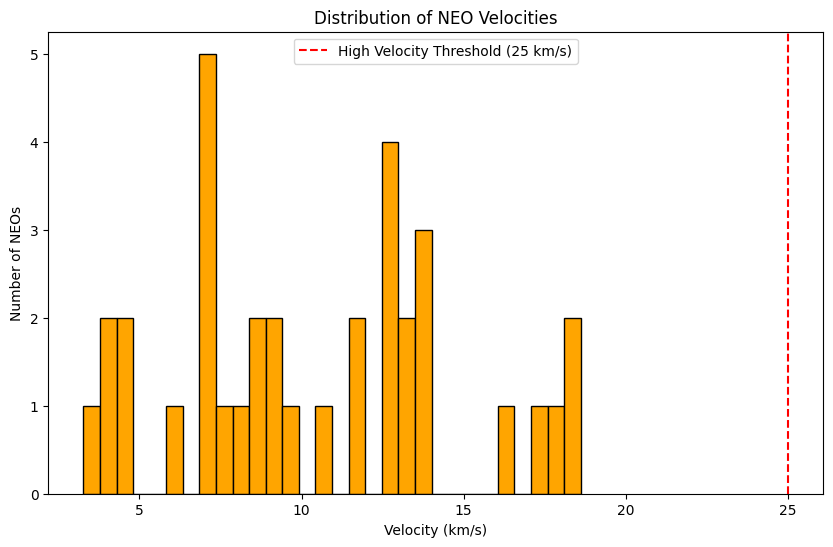

In [26]:
plt.figure(figsize=(10,6))
plt.hist(df[col_velocity].dropna(), bins=30, color='orange', edgecolor='black')
plt.axvline(25, color='red', linestyle='--', label='High Velocity Threshold (25 km/s)')
plt.xlabel('Velocity (km/s)')
plt.ylabel('Number of NEOs')
plt.title('Distribution of NEO Velocities')
plt.legend()
plt.show()


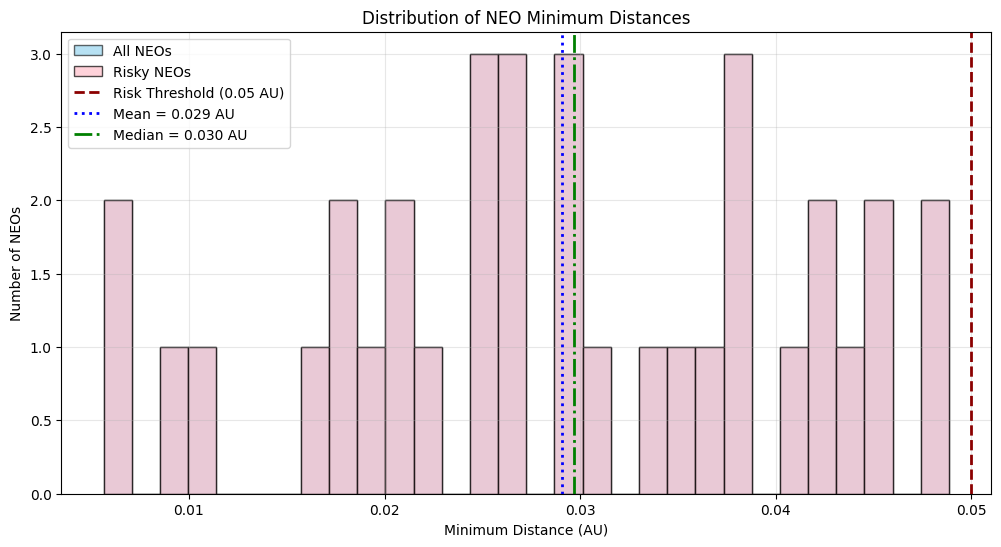

In [32]:
plt.figure(figsize=(12,6))

# Histogram for all NEOs
plt.hist(df[col_distance_min].dropna(), bins=30, color='skyblue', edgecolor='black', alpha=0.6, label='All NEOs')

# Histogram for risky NEOs
plt.hist(df[df['Risk']][col_distance_min].dropna(), bins=30, color='pink', edgecolor='black', alpha=0.7, label='Risky NEOs')

# Threshold line
plt.axvline(threshold_au, color='darkred', linestyle='--', linewidth=2, label=f'Risk Threshold ({threshold_au} AU)')

# Mean and median
mean_dist = df[col_distance_min].mean()
median_dist = df[col_distance_min].median()
plt.axvline(mean_dist, color='blue', linestyle=':', linewidth=2, label=f'Mean = {mean_dist:.3f} AU')
plt.axvline(median_dist, color='green', linestyle='-.', linewidth=2, label=f'Median = {median_dist:.3f} AU')

plt.xlabel('Minimum Distance (AU)')
plt.ylabel('Number of NEOs')
plt.title('Distribution of NEO Minimum Distances')
plt.legend()
plt.grid(alpha=0.3)
plt.show()
